# Function approximation notebook

This notebook is suppose to demonstrate how one can approximate a function, $\mathbb{R} \to \mathbb{R}$, with a neural network.

This notebook is using the PyTorch framework.

## Initialising the notebook

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

import numpy as np

import matplotlib.pyplot as plt
# If you do not have a dark theme for jupyter,
# you may want to get rid of this:
plt.style.use('dark_background')

import random

### Network

In the below we implement the network. Let list some details

* It has one hidden layer of size `H`
* Activation functions are $\tanh$
* Takes one input, returns one output; $\mathbb{R} \to \mathbb{R}$.

In [2]:
class FuncNN(nn.Module):
    """
        FuncNN
        
    Has one input, a hidden layer, and one output. This should emulate a function.
    """
    
    def __init__(self, H):
        super(FuncNN, self).__init__()
        
        if torch.cuda.is_available():
            self.hidden1 = nn.Linear(1, H).cuda()
            self.hidden2 = nn.Linear(H, 1).cuda()
        else:
            self.hidden1 = nn.Linear(1, H)
            self.hidden2 = nn.Linear(H, 1)
        
    def forward(self, x):
        ret = x
        ret = self.hidden1(ret)
        ret = nn.functional.tanh(ret)
        ret = self.hidden2(ret)
        ret = nn.functional.tanh(ret)
        ret = ret
        return ret

### Training functions

In the below we implement a training step and a training loop. These assume that you are working with optimisers. See the sine example later in this notebook for a demonstration. Some partial details:

* The loss function is hard coded in the function below and taken to be `MSELoss`
* The order in which preditions are computed from input data is randomised, but loss is calculated after all points are computed.

This is implemented assuming that you want to train the same $x$ (input) and $y$ (outputs) on the training interval for all epochs.

In [3]:
def trainStep(x, y, funcNN, optim):
    """
        trainStep(inputs, outputs, funcNN, optim)
        
    Trains `funcNN` network one step towards `outputs` using `optim` optimiser.
    """
    # Zero gradients from previous steps
    optim.zero_grad()
    
    # Choose loss function
    loss_func = nn.MSELoss()
    
    # Calculate predictions
    y_preds = Variable(torch.zeros(y.size(0)))
    if torch.cuda.is_available():
        y_preds = y_preds.cuda()
    # mess up the order to train more uniformly
    order = list(range(y.size(0)))
    random.shuffle(order)
    for i in order:
        y_preds[i] = funcNN(x[i])
    
    # Calculate loss
    loss = loss_func(y_preds, y)
    # Backpropagate
    loss.backward()
    # Step
    optim.step()
    
    return loss, y_preds

def trainLoop(x, y, funcNN, optim, iterations):
    """
        trainLoop(input, output, funcNN, optim, iterations)
        
    Loops `trainStep()` `iterations` times, returning losses and all preditions made.
    """
    # Place to save all losses and predictions to analyse later
    losspoints = []
    y_predpoints = []
    # Loop
    for i in range(iterations):
        loss, y_preds = trainStep(x, y, funcNN, optim)
        # Add these for analysis
        losspoints.append(loss.data[0])
        y_predpoints.append(list(y_preds.data))
    
    return losspoints, y_predpoints

## Sine example

In the example below we will try and teach the previously implemented network the sine-function. Also here some details:

 * In the below the `Adam` optimiser has been chosen. Other optimisers seems to perform very bad.

In [9]:
# Initialise NN
H = 20
sinNN = FuncNN(H)

# Init input data
ival = [random.random()*-20, random.random()*20]
npoints = 40

xs = np.linspace(*ival, num=npoints)
xs = Variable(torch.FloatTensor(
    xs
))
if torch.cuda.is_available():
    xs = xs.cuda()

# Init output data
ys_sin = np.linspace(*ival, num=npoints)
ys_sin = np.sin(ys_sin)
ys_sin = Variable(torch.FloatTensor(
    ys_sin
))
if torch.cuda.is_available():
    ys_sin = ys_sin.cuda()

# Its optimiser:
lr = 0.01
sinNN_opt = optim.Adam(sinNN.parameters(), lr=lr)

# Start training
losses, predictionpoints = trainLoop(xs, ys_sin, sinNN, sinNN_opt, 2000)

### Plotting the Sine experiment

In the below we plot some features of the training and the resulting neural net. These plots are

* Plot of the loss during training.
* A plot comparing the actual (numpy-sine) and prediction (sine from neural net).
* A plot showing how the predictions have evolved during training.

And what does it mean that we teach the neural net the sine function? To answer this we plot

* Extrapolation: Plot the numpy sine and the neural net sine outside the training interval. (the neural net performs bad here)
* Interpolation: Plot to compare numpy and the neural net at many more points than trained, in the training interval. (the network performs quite well here)

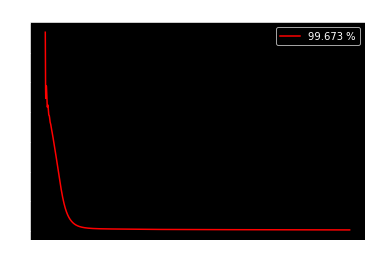

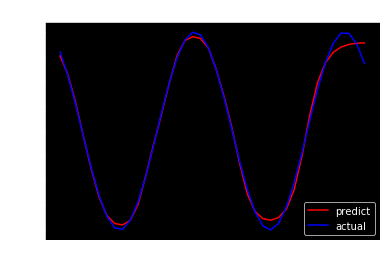

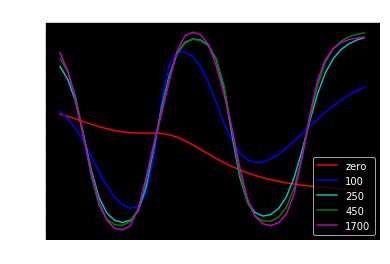

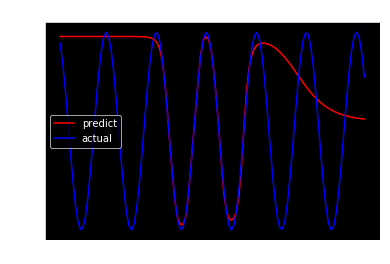

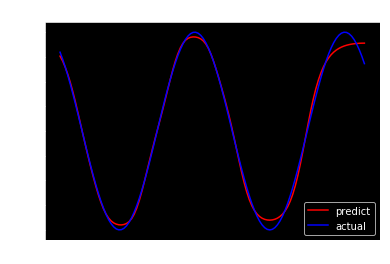

In [10]:
# Make some plots

# Calculate points (for plotting)
plotpoints = [ sinNN(x).data[0] for x in xs ]

# Error/loss plot and final accuracy value
plt.figure()
lplot, = plt.plot(losses, 'r', label=str(round(100*(1-losses[-1]), 3))+" %")
plt.legend(handles=[lplot])
plt.title('Loss plot')
plt.show()

# Actual and prediction comparison plot
plt.figure()
pplot, = plt.plot(list(xs.data), plotpoints, 'r', label="predict")
aplot, = plt.plot(list(xs.data), list(ys_sin.data), 'b', label="actual")
plt.legend(handles=[pplot, aplot])
plt.title('Actual vs. prediction plots')
plt.show()

# Evolution comparison plot
plt.figure()
plot1, = plt.plot(list(xs.data), predictionpoints[0], 'r', label="zero")
plot2, = plt.plot(list(xs.data), predictionpoints[100], 'b', label="100")
plot3, = plt.plot(list(xs.data), predictionpoints[250], 'c', label="250")
plot4, = plt.plot(list(xs.data), predictionpoints[450], 'g', label="450")
plot5, = plt.plot(list(xs.data), predictionpoints[1700], 'm', label="1700")
plt.legend(handles=[plot1, plot2, plot3, plot4, plot5])
plt.title('Epoch evolution plots')
plt.show()

# Extrapolation plots
extraival = [ival[0]-(ival[1]-ival[0]), ival[1]+(ival[1]-ival[0])]
extranpoints = 3*npoints
extra_xs = np.linspace(*extraival, num=extranpoints)
extra_xs = Variable(torch.FloatTensor(
    extra_xs
))
if torch.cuda.is_available():
    extra_xs = extra_xs.cuda()
    
extraplotpoints = [ sinNN(x).data[0] for x in extra_xs ]
ys_sinextra = [ np.sin(x) for x in list(extra_xs.data) ]

plt.figure()
pplot, = plt.plot(list(extra_xs.data), extraplotpoints, 'r', label="predict")
aplot, = plt.plot(list(extra_xs.data), ys_sinextra, 'b', label="actual")
plt.legend(handles=[pplot, aplot])
plt.title('Extrapolation plots')
plt.show()

# Interpolation plots
internpoints = 3*npoints
inter_xs = np.linspace(*ival, num=internpoints)
inter_xs = Variable(torch.FloatTensor(
    inter_xs
))
if torch.cuda.is_available():
    inter_xs = inter_xs.cuda()
    
interplotpoints = [ sinNN(x).data[0] for x in inter_xs ]
ys_sininter = [ np.sin(x) for x in list(inter_xs.data) ]

plt.figure()
pplot, = plt.plot(list(inter_xs.data), interplotpoints, 'r', label="predict")
aplot, = plt.plot(list(inter_xs.data), ys_sininter, 'b', label="actual")
plt.legend(handles=[pplot, aplot])
plt.title('Interpolation plots')
plt.show()